<a href="https://colab.research.google.com/github/JLMuehlbauer/food-sales-prediction/blob/main/Project1_Part5_JacksonMuehlbauer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Part 5

Jackson Muehlbauer

Date: 12/15/2022

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import make_pipeline

In [2]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading Data
path = '/content/drive/My Drive/Colab Notebooks/Raw Data/sales_predictions (1).csv'
df = pd.read_csv(path)

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Cleaning Data
- Dropping Duplicates
- Fixing inconsistencies

In [4]:
# Making df copy for insurance
df_ml = df.copy()
df_ml.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df_ml.duplicated().sum()

0

There are no duplicated rows in this dataset

In [6]:
# looking at the values and the number of unique values in each categorical column
for column in df_ml.select_dtypes(['object']).columns:
  print(column)
  print(df_ml[column].value_counts())
  print(df_ml[column].nunique(), '\n')


Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64
1559 

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
5 

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
16 

Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OU

There are inconsistencies in the Item_Fat_Content column. We know that the only categories for this column are Low Fat and Regular. Thus, it should be safe from a "data leakage" perspective to correct these inconsistencies on the entire data set. I will use .replace(dict) on the entire data set. 

In [7]:
replace_dict = {'LF': 'Low Fat',
                'low fat': 'Low Fat',
                'reg' : 'Low Fat'}
# Applying the replacement
df_ml['Item_Fat_Content'].replace(replace_dict, inplace = True)

# Checking that changes were applied
df_ml['Item_Fat_Content'].value_counts()

Low Fat    5634
Regular    2889
Name: Item_Fat_Content, dtype: int64

I also noticed before that the Item_Identifier column is categorical and has many unique entries and the largest value count is only 10. For the purpose of machine learning, this will not be a useful feature. Therefore, I will drop this column.

In [8]:
# Dropping the Item_Identifier column
df_ml.drop(columns = ['Item_Identifier'], inplace = True)

# Checking the drop
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


From above, I noticed that one (or more) of the categorical features are ordinal.
- Outlet_Size has Small, Medium, and High
- Outlet_Location_Type and Outlet_Type have categories with numbering... However, without more information about Tier 1, Tier 2, Supermarket1, Supermarket2 describe, I will consider these both as nominal features for now. 
- Item_Fat_Content could also be considered ordinal. There is a low and medium level of fat, but there are only two options so I don't know if there's very much value in considering this feature as ordinal. 

I will plan to ordinal encode Outlet_Size with .replace() on the full dataset. This encoding is done without information from the "test" set so it should not correspond to a data leak.

In [9]:
# Ordinal encoding Outlet_Size
ordinal_dict = {'Small':0,
                'Medium': 1,
                'High': 2}

# Encoding
df_ml['Outlet_Size'].replace(ordinal_dict, inplace = True)

# Checking column and dtype
df_ml['Outlet_Size'].head()

0    1.0
1    1.0
2    1.0
3    NaN
4    2.0
Name: Outlet_Size, dtype: float64

In [10]:
# Checking for null values
print(df_ml.info(), '\n')
print(df_ml.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   float64
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 732.6+ KB
None 

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility           

There are missing values in both the Item_Weight and Outlet_Size columns. Both of these columns are numerical, the missing values will need to be imputed after splitting our data.

## Splitting and Preprocessing Data

> Indented block



In [11]:
# Target and Feature Matrix
target = 'Item_Outlet_Sales'
X = df_ml.drop(columns = [target])
y = df_ml[target]

print(X.head())
print(y.head())

   Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
0         9.30          Low Fat         0.016047                  Dairy   
1         5.92          Regular         0.019278            Soft Drinks   
2        17.50          Low Fat         0.016760                   Meat   
3        19.20          Regular         0.000000  Fruits and Vegetables   
4         8.93          Low Fat         0.000000              Household   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  \
0  249.8092            OUT049                       1999          1.0   
1   48.2692            OUT018                       2009          1.0   
2  141.6180            OUT049                       1999          1.0   
3  182.0950            OUT010                       1998          NaN   
4   53.8614            OUT013                       1987          2.0   

  Outlet_Location_Type        Outlet_Type  
0               Tier 1  Supermarket Type1  
1               Tier 3

In [12]:
# Splitting data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [13]:
# Instantiate Column Selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')


In [14]:
# Instantiate numerical imputer to fill missing values
# I chose the mean as I have no reason to believe I shouldn't. 
# When I had originally explored this data, the Item_Weight and Outlet_Size where not abnormally distributed.
# I could have also chosen to use the median.

num_imputer = SimpleImputer(strategy = 'mean')

# No need for categorical imputer



In [15]:
# Instantiate StandardScaler and OneHotEncoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')


In [16]:
# Making a pipeline for numerical columns (no need for categorical columns)
num_pipe = make_pipeline(num_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [17]:
# Making tuples for categorical and numerical for a column transformer
cat_tuple = (ohe, cat_selector)
num_tuple = (num_pipe, num_selector)

In [18]:
# Instantiate column transformer, dropping unprocessed columns
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder = 'drop')

#Checking processor
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f79ff0a1160>),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f79ff0a1190>)])

In [19]:
# Fitting to the train data
preprocessor.fit(X_train)

#Transforming train and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [20]:
# Checking data
print(np.isnan(X_train_processed).sum())
print(X_train_processed.shape)

0
(6392, 40)


No missing values!

40 columns > 10, good indication that OneHotEncoder worked as intended. 

## Linear Regression Model

In [21]:
# import libraries
from sklearn.linear_model import LinearRegression

In [22]:
# Instantiate linear regression
lin_reg = LinearRegression()

# Make Model pipeline
lin_pipe = make_pipeline(preprocessor, lin_reg)

In [23]:
# Fit the model pipeline to the train set
lin_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f79ff0a1160>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f79ff0a1190>)])),
                ('linearregression', LinearRegression())])

In [24]:
# Predict using the liner regression pipeline
train_pred = lin_pipe.predict(X_train)
test_pred = lin_pipe.predict(X_test)

In [25]:
# Import contents to evaluate model performance 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

In [26]:
# Evaluate model performance
# R-squared
train_R2 = r2_score(y_train, train_pred)
test_R2 = r2_score(y_test, test_pred)

# Root mean squared error
train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))
test_RMSE= np.sqrt(mean_squared_error(y_test, test_pred))

print(f'The R-squared value for the train and test sets are {round(train_R2, 4)} and {round(test_R2, 4)}, respectively')
print(f'The root mean squared error value for the train sets and test are {round(train_RMSE, 2)} and {round(test_RMSE, 2)}, respectively')

The R-squared value for the train and test sets are 0.5601 and 0.5685, respectively
The root mean squared error value for the train sets and test are 1141.03 and 1091.05, respectively


In [27]:
# Retrieving context for RMSE
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Evaluation of the Linear Regression Model

#### R-Squared
The R-squared values for both the Train and Test sets are fairly low. According to the test set R-squared, the linear regression model can use the available features to account for about 56.9% of the variance in the Item Outlet Sales (target). This performance is not particularly good. 

#### RMSE
The RMSE value for the test set using the linear regression model was \$1091.05. This is a measure of the average error (while punishing larger errors). This is very poor performance when comparing it to the mean item outlet sales of $2181.29. This means that the RMSE is roughly 50% of the average.

## Simple Regression Tree Model

In [28]:
# Import content
from sklearn.tree import DecisionTreeRegressor

In [29]:
# Instantiate the decision regression tree
dec_tree = DecisionTreeRegressor(random_state = 42)

# Make decision tree pipeline
tree_pipe = make_pipeline(preprocessor, dec_tree)
# Don't actually need to scale data for the decision tree but this processor also imputes and ohe encodes

# Fit the decision tree to the train data
tree_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f79ff0a1160>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f79ff0a1190>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [30]:
# Evaluate the performance 
train_R2_tree  = tree_pipe.score(X_train, y_train)
test_R2_tree  = tree_pipe.score(X_test, y_test)

print('Default decision regression tree:')
print(f'The R-squared value for the train and test sets are {round(train_R2_tree, 4)} and {round(test_R2_tree, 4)}, respectively')

Default decision regression tree:
The R-squared value for the train and test sets are 1.0 and 0.1944, respectively


The difference between the train and test R-squared values indicate significant overfitting of the train data (high variance). This model needs to be optimized. 


In [31]:
# Getting the depth of the default decision tree
dec_tree.get_depth()

40

In [34]:
# Optimize the decision tree
depths = range(2, tree_pipe['decisiontreeregressor'].get_depth()+1, 1)
scores = pd.DataFrame(index = depths, columns = ['Train R-squared', 'Test R-squared'])

for depth in depths:
  # initialize
  dec_tree_temp = DecisionTreeRegressor(random_state = 42, max_depth = depth)
  # make pipeline
  tree_pipe_temp = make_pipeline(preprocessor, dec_tree_temp)
  # Fit to train data
  tree_pipe_temp.fit(X_train, y_train)
  # Get R-squared for train and test
  train_score = tree_pipe_temp.score(X_train, y_train)
  test_score = tree_pipe_temp.score(X_test, y_test)
  # Add to scores dataframe
  scores.loc[depth, 'Train R-squared'] = train_score
  scores.loc[depth, 'Test R-squared'] = test_score


In [35]:
sorted_scores = scores.sort_values(by = 'Test R-squared', ascending = False)
sorted_scores.head()

,Train R-squared,Test R-squared
5,0.603929,0.594725
4,0.582625,0.584005
6,0.615149,0.582271
7,0.626838,0.576759
8,0.644024,0.55837


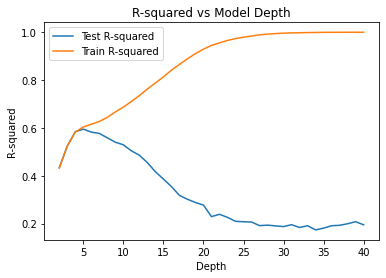

In [45]:
#Plotting the performance vs the depth 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.lineplot(x = scores.index, y = scores['Test R-squared'], label = 'Test R-squared');
sns.lineplot(x = scores.index, y = scores['Train R-squared'], label = 'Train R-squared');
plt.ylabel('R-squared');
plt.xlabel('Depth');
plt.title('R-squared vs Model Depth');
plt.legend();

The optimal tree depth is 5 for the single decision tree. The final decision tree depth will be set to 5. As the depth increases, the model tends to overfit on the train data leading to high variance in the model. 

In [37]:
# Using the optimized depth, remaking the decision tree
dec_tree_final  = DecisionTreeRegressor(random_state = 42, max_depth = sorted_scores.index[0])

# Making the pipeline
tree_pipe_final = make_pipeline(preprocessor, dec_tree_final)

# Fit final pipeline to the train data
tree_pipe_final.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f79ff0a1160>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f79ff0a1190>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [46]:
# Calculate R-squared
train_R2_tree_final  = tree_pipe_final.score(X_train, y_train)
test_R2_tree_final  = tree_pipe_final.score(X_test, y_test)

# Display R-squared
print('Decision regression tree w/max depth of 5:')
print(f'The R-squared value for the train and test sets are {round(train_R2_tree_final, 4)} and {round(test_R2_tree_final, 4)} \n')

# Calculate RMSE
train_pred_tree = tree_pipe_final.predict(X_train)
test_pred_tree = tree_pipe_final.predict(X_test)

train_RMSE_tree = np.sqrt(mean_squared_error(y_train, train_pred_tree))
test_RMSE_tree = np.sqrt(mean_squared_error(y_test, test_pred_tree))

# Display RMSE
print('Decision regression tree w/max depth of 5:')
print(f'The RMSE value for the train and test sets are {round(train_RMSE_tree, 2)} and {round(test_RMSE_tree, 2)}')



Decision regression tree w/max depth of 5:
The R-squared value for the train and test sets are 0.6039 and 0.5947 

Decision regression tree w/max depth of 5:
The RMSE value for the train and test sets are 1082.66 and 1057.42


## Model Recommendation
The recommended model is the decision regression tree over the linear regression. 

Overall, the single decision regression tree performed slightly better than the linear regression in both R-squared and RMSE calculated from the test set. 

The test set R-squared for the single decision tree was 0.5947 while the same metric for the linear regression model was 0.5685. The higher value for decision tree indicates that the model better can better explain the variance in the item outlet sales with the available features. 

The test set RMSE for the decision tree was \$1057.42, the same metric for the linear regression was $1091.05. These are very close in value but there is still a slight edge for the decision tree. Overall, the decision tree predicts with slightly lower residuals.

